# DSCI Group Project -- Group 42

## Research Question

In [5]:
library(tidyverse)
library(dplyr)
library(tidymodels)
set.seed(6666)

players <- read_csv("players.csv")


clean_players <- players |>
    mutate(subscribe = as.factor(subscribe),
           experience = as.factor(experience)) |>
    select(-hashedEmail, -gender, -name)


clean_players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17
Regular,TRUE,0.0,19
Amateur,FALSE,0.0,21
Amateur,TRUE,0.1,47


## Setting Up Training and Testing Data

In [7]:
players_split <- initial_split(clean_players, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

## Creating a Recipe and Model

In [8]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours)
players_recipe

knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: Age and played_hours

• Centering for: Age and played_hours



## Using 5 Fold Cross Validation and Train the Model

In [9]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 103, by = 1))

knn_tuned_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tuned) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





## Visualize Accuracy with Different K Values

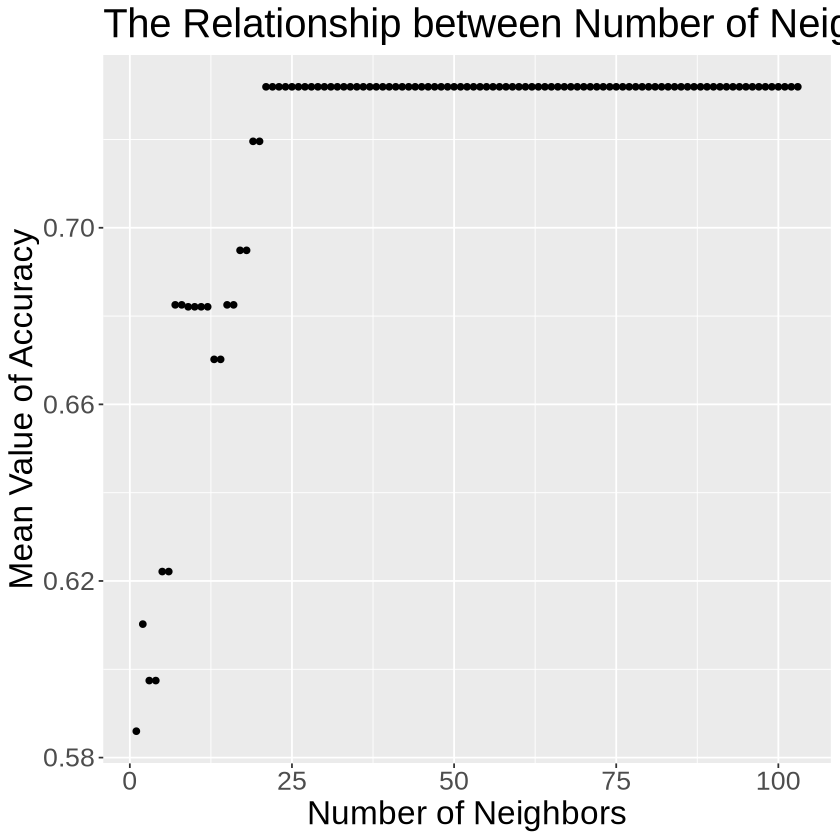

In [10]:
accuracy <- knn_tuned_fit |>
    filter(.metric == "accuracy")
accuracy_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Number of Neighbors",
         y = "Mean Value of Accuracy") +
    ggtitle("The Relationship between Number of Neighbors (k) and Their Mean Value") +
    theme(text = element_text(size = 20))
accuracy_plot

## Find the Best K and Fitting it in Training Data

In [13]:
best_k <- accuracy |>
    filter(mean == max(mean)) |>
    pull(neighbors)
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = 29) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_best) |>
    fit(players_test)


## Predict Using Testing Data

In [14]:
subscribe_predictions <- predict(knn_best_fit, players_test) |>
    bind_cols(players_test)
subscribe_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
subscribe_metrics
subscribe_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333
kap,binary,0.0000000


.pred_class,experience,subscribe,played_hours,gender
<fct>,<fct>,<fct>,<dbl>,<fct>
TRUE,Veteran,FALSE,0.0,Male
TRUE,Amateur,FALSE,0.0,Male
TRUE,Pro,TRUE,0.0,Male
TRUE,Amateur,TRUE,0.2,Male
TRUE,Veteran,TRUE,0.0,Non-binary
TRUE,Regular,TRUE,0.3,Male
TRUE,Amateur,FALSE,0.1,Female
TRUE,Beginner,TRUE,0.0,Male
TRUE,Amateur,TRUE,1.8,Male
